# Building an Image Classifier Deep Network applying Transfer Learning

In [ ]:
# import the required libraries
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import numpy as np
import os

In [ ]:
# NB! Run this cell ONLY IF you're using Colab. It will clone the GitHub repo and
# point to that directory.
!git clone https://github.com/andreoniriccardo/transfer-learning-image-classifier.git
os.chdir('transfer-learning-image-classifier')

Cloning into 'transfer-learning-image-classifier'...
remote: Enumerating objects: 370, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 370 (delta 5), reused 21 (delta 3), pack-reused 347
Receiving objects: 100% (370/370), 121.01 MiB | 42.59 MiB/s, done.
Resolving deltas: 100% (6/6), done.


## Dataset creation

In [ ]:
# dataset's directory path
directory = "data/"

batch_size = 32
image_size = (160,160) # resize the images to 160x160

# create training and validation sets
# use image_dataset_from_directory to load the images
# set a validation split and specify the subset ('training' or 'validation')
# set the random seeds to match eachother (to avoid overlapping of the images in
# train and validation sets)

train_set = tf.keras.utils.image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=batch_size,
                                             image_size=image_size,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_set = tf.keras.utils.image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=batch_size,
                                             image_size=image_size,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


In [ ]:
# print some images
# use .class_names attribute to retrieve the classes of the images from the dicrectories names
class_names = train_set.class_names
print(class_names)

['alpaca', 'not_alpaca']


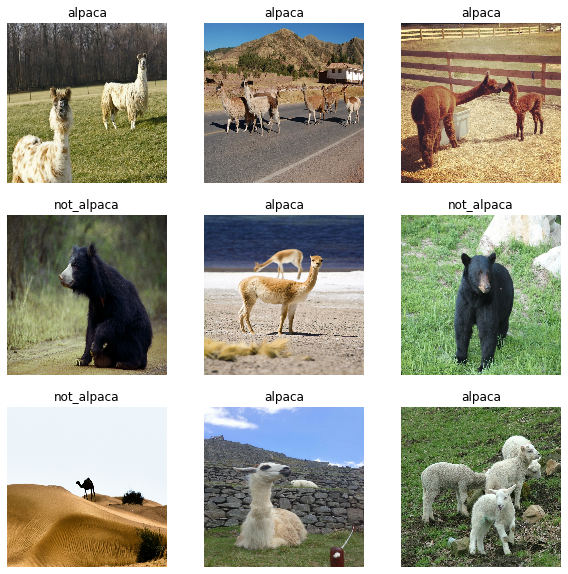

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_set.take(1): # take 1 batch randomly
    for i in range(9): # print 9 images of that batch
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Import pre-trained model

In [ ]:
# explore the MobileNetV2 network
image_shape = image_size + (3,)
pre_trained_model = tf.keras.applications.MobileNetV2(input_shape=image_shape,
                                               include_top=True,
                                               weights='imagenet')

In [ ]:
pre_trained_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_4[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [ ]:
len(pre_trained_model.layers)

156

In [ ]:
# load the pre-trained model without the final layers
image_shape = image_size + (3,)
pre_trained_model = tf.keras.applications.MobileNetV2(input_shape=image_shape,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
# normalize the inputs to the range [-1, 1]
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
# freeze the base model by making it non trainable
pre_trained_model.trainable = False
# define the input layer
inputs = tf.keras.Input(shape=image_shape) 
# preprocess the inputs
x = preprocess_input(inputs)
# add the pre-trained (not trainable) model
x = pre_trained_model(x, training=False)
# add a pooling layer
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# add a dropout layer for regularization
x = tf.keras.layers.Dropout(0.2)(x)
# add the output layer
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
# define the model with its inputs and outputs
model = tf.keras.Model(inputs, outputs)

In [ ]:
# compile the model
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
# train the model
history = model.fit(train_set, validation_data=validation_set, epochs=10)

Epoch 1/10
9/9 [==============================] - 14s 1s/step - loss: 0.6195 - accuracy: 0.6489 - val_loss: 0.4970 - val_accuracy: 0.7385
Epoch 2/10
9/9 [==============================] - 7s 602ms/step - loss: 0.4200 - accuracy: 0.8359 - val_loss: 0.3527 - val_accuracy: 0.9077
Epoch 3/10
9/9 [==============================] - 7s 595ms/step - loss: 0.3345 - accuracy: 0.8740 - val_loss: 0.2924 - val_accuracy: 0.9077
Epoch 4/10
9/9 [==============================] - 7s 590ms/step - loss: 0.2593 - accuracy: 0.9198 - val_loss: 0.2539 - val_accuracy: 0.9231
Epoch 5/10
9/9 [==============================] - 7s 586ms/step - loss: 0.2065 - accuracy: 0.9504 - val_loss: 0.2224 - val_accuracy: 0.9231
Epoch 6/10
9/9 [==============================] - 7s 594ms/step - loss: 0.1814 - accuracy: 0.9542 - val_loss: 0.2033 - val_accuracy: 0.9385
Epoch 7/10
9/9 [==============================] - 7s 595ms/step - loss: 0.1672 - accuracy: 0.9542 - val_loss: 0.1778 - val_accuracy: 0.9692
Epoch 8/10
9/9 [======

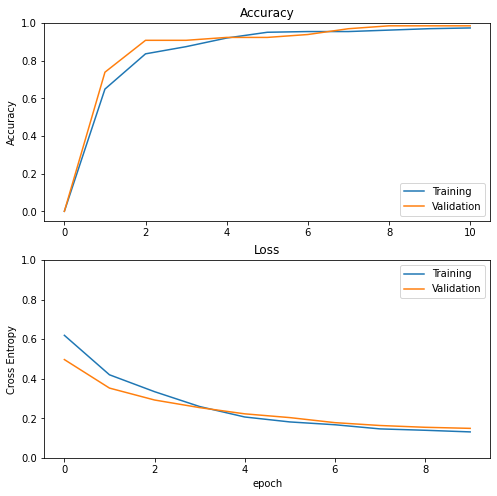

In [ ]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training')
plt.plot(val_acc, label='Validation')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training')
plt.plot(val_loss, label='Validation')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# predict images
test_path = "test_images/"
test_imgs = os.listdir(test_path)

for i in test_imgs:
    image_path = os.path.join(test_path, i)
    img = Image.open(image_path).convert('RGB').resize((160, 160), Image.ANTIALIAS)
    img = np.array(img)
    prediction_prob = model.predict(img[None,:,:])
    prediction = 'Alpaca' if prediction_prob < 0.5 else 'Not alpaca'
    print(image_path, prediction, prediction_prob)


test_images/t11.jpg Alpaca [[0.3749833]]
test_images/t14.jpg Alpaca [[0.02219871]]
test_images/t06.jpg Alpaca [[0.01716113]]
test_images/t13.jpg Alpaca [[0.10567904]]
test_images/t04.jpg Not alpaca [[0.5408186]]
test_images/t02.jpg Not alpaca [[0.9250907]]
test_images/t10.jpg Alpaca [[0.37337646]]
test_images/t09.jpg Not alpaca [[0.8785708]]
test_images/t03.jpg Not alpaca [[0.9846866]]
test_images/t05.jpg Not alpaca [[0.98737305]]
test_images/t07.jpg Alpaca [[0.09446004]]
test_images/t12.jpg Alpaca [[0.25742316]]
test_images/t08.jpg Alpaca [[0.01843929]]
test_images/t15.jpg Not alpaca [[0.8730666]]
test_images/t01.jpg Alpaca [[0.04613042]]


# With Data Augmentation

In [ ]:
# freeze the base model by making it non trainable
pre_trained_model.trainable = False
# define the input layer
inputs = tf.keras.Input(shape=image_shape) 
# apply data augmentation
x = tf.keras.Sequential([tf.keras.layers.RandomFlip('horizontal'),
                         tf.keras.layers.RandomRotation(0.2)])(inputs)

# preprocess the augmented inputs
x = preprocess_input(x)
# add the pre-trained (not trainable) model
x = pre_trained_model(x, training=False)
# add a pooling layer
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# add a dropout layer for regularization
x = tf.keras.layers.Dropout(0.2)(x)
# add the output layer
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
# define the model with its inputs and outputs
model_augmented = tf.keras.Model(inputs, outputs)

In [ ]:
model_augmented.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

In [ ]:
# compile the model
base_learning_rate = 0.001
model_augmented.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])
# train the model
history_augmented = model_augmented.fit(train_set, validation_data=validation_set, epochs=20)

Epoch 1/20
9/9 [==============================] - 12s 762ms/step - loss: 0.2224 - accuracy: 0.9160 - val_loss: 0.1309 - val_accuracy: 0.9538
Epoch 2/20
9/9 [==============================] - 7s 666ms/step - loss: 0.2152 - accuracy: 0.9198 - val_loss: 0.1191 - val_accuracy: 0.9692
Epoch 3/20
9/9 [==============================] - 7s 664ms/step - loss: 0.2259 - accuracy: 0.9160 - val_loss: 0.1203 - val_accuracy: 0.9538
Epoch 4/20
9/9 [==============================] - 7s 657ms/step - loss: 0.2094 - accuracy: 0.9198 - val_loss: 0.1132 - val_accuracy: 0.9846
Epoch 5/20
9/9 [==============================] - 7s 672ms/step - loss: 0.1967 - accuracy: 0.9275 - val_loss: 0.1128 - val_accuracy: 0.9538
Epoch 6/20
9/9 [==============================] - 7s 667ms/step - loss: 0.1960 - accuracy: 0.9275 - val_loss: 0.1074 - val_accuracy: 0.9846
Epoch 7/20
9/9 [==============================] - 7s 664ms/step - loss: 0.1674 - accuracy: 0.9427 - val_loss: 0.1076 - val_accuracy: 0.9692
Epoch 8/20
9/9 [===

In [ ]:
# predict images
# get number of images to test
test_path = "test_images/"
test_imgs = os.listdir(test_path)
#num_tests = len(test_imgs)

for i in test_imgs:
    image_path = os.path.join(test_path, i)
    img = Image.open(image_path).convert('RGB').resize((160, 160), Image.ANTIALIAS)
    img = np.array(img)
    prediction = model_augmented.predict(img[None,:,:])
    print(image_path,prediction)

test_images/t11.jpg [[0.1029796]]
test_images/t14.jpg [[0.01107088]]
test_images/t06.jpg [[0.0074549]]
test_images/t13.jpg [[0.00213569]]
test_images/t04.jpg [[0.72032976]]
test_images/t02.jpg [[0.9854841]]
test_images/t10.jpg [[0.6669749]]
test_images/t09.jpg [[0.2536552]]
test_images/t03.jpg [[0.9014208]]
test_images/t05.jpg [[0.99720025]]
test_images/t07.jpg [[0.0441601]]
test_images/t12.jpg [[0.08119759]]
test_images/t08.jpg [[0.0130958]]
test_images/t15.jpg [[0.96545273]]
test_images/t01.jpg [[0.03634548]]
